# Visualizacion varias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from scipy import stats
import seaborn as sns
import geopandas as gpd
import matplotlib
import ipywidgets as widgets
from ipywidgets import interact
matplotlib.style.use("ggplot")
import folium
from folium.plugins import DualMap 
import mapas
from shapely.geometry import Polygon, MultiPolygon

## Evolucion de genero en grupo de carreras

In [15]:
df_evolucion_carreras = pd.read_csv('data/output/carreras_evolucion_genero.csv',delimiter=',')
df_evolucion_grupos_carreras = pd.read_csv('data/output/grupo_carreras_evolucion_genero.csv',delimiter=',')

In [3]:
df_evolucion_carreras[
    (df_evolucion_carreras.carrera_grupo == "Abogado") &
    (df_evolucion_carreras.anio == 2010)
]

,anio,carrera_grupo,estudiantes_total,estudiantes_varones,estudiantes_mujeres,nuevos_inscriptos_total,nuevos_inscriptos_varones,nuevos_inscriptos_mujeres,egresados_total,egresados_varones,egresados_mujeres,estudiantes_mujeres_pct,inscripciones_mujeres_pct
0,2010,Abogado,212710.0,76898.0,100320.0,46024.0,18303.0,22110.0,12485.0,3743.0,4973.0,0.471628,0.480402


In [4]:
variables_carreras_evolucion = df_evolucion_carreras.carrera_grupo.unique()
@interact(carrera_grupo = sorted(variables_carreras_evolucion))
def generate_chart_evolucion_grupos(carrera_grupo):
    serie_grupo_carrera = df_evolucion_carreras[df_evolucion_carreras.carrera_grupo == carrera_grupo][[
        "anio","estudiantes_mujeres_pct"
    ]]
    return serie_grupo_carrera.set_index("anio").plot()
    
#agregar mas de un filtro para ir comparando
#modificar en ETL abogacia y derecho
#apertura por carreras para entender donde hace el pico y decrecimiento tech - cambiar pKEY por carrera y grupo carrera - grafico exploratorio
#segunda tabla de ETL donde haya grupo carrera (carrera) + universidades
#grafico con valores absolutos - apilados o algo que represente orden de magnitud año por default 

interactive(children=(Dropdown(description='carrera_grupo', options=('Abogado', 'Arquitectura', 'Arte', 'Depor…

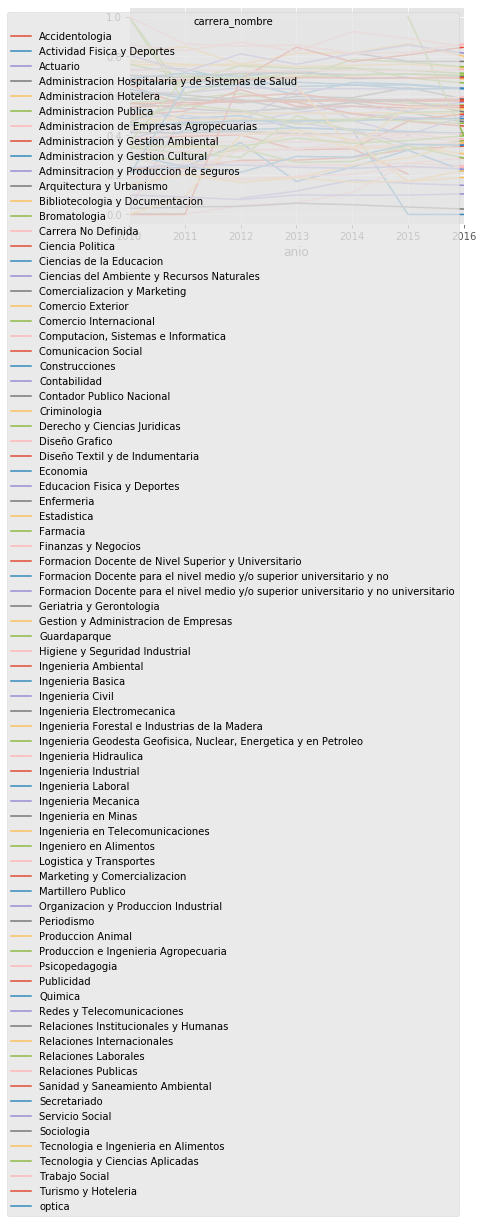

In [26]:
#chequear clasificacion y ETL
#Una vez revisado, armar funcion para este tipo de grafico con un grupo de carrera, me devuelve todas las carreras.
grupo = 'Economicas'
df_grupo_carrera = df_evolucion_grupos_carreras[df_evolucion_grupos_carreras.carrera_grupo == grupo][[
        "anio", "estudiantes_mujeres_pct", 'carrera_nombre', 'carrera_grupo'
    ]]
df_grupo_carrera.pivot_table(index='anio', columns='carrera_nombre', values='estudiantes_mujeres_pct').plot()

In [4]:
variables_carreras_evolucion = df_evolucion_grupos_carreras.carrera_grupo.unique()
@interact(carrera_grupo = sorted(variables_carreras_evolucion))
def generate_chart_evolucion_carreras(carrera_grupo):
    df_grupo_carrera = df_evolucion_grupos_carreras[df_evolucion_grupos_carreras.carrera_grupo == carrera_grupo][[
        "anio", "estudiantes_mujeres_pct"
    ]]
    return serie_grupo_carrera.set_index("anio").plot()
    
#agregar mas de un filtro para ir comparando
#modificar en ETL abogacia y derecho
#apertura por carreras para entender donde hace el pico y decrecimiento tech - cambiar pKEY por carrera y grupo carrera - grafico exploratorio
#segunda tabla de ETL donde haya grupo carrera (carrera) + universidades
#grafico con valores absolutos - apilados o algo que represente orden de magnitud año por default 

interactive(children=(Dropdown(description='carrera_grupo', options=('Abogado', 'Arquitectura', 'Arte', 'Depor…

## Mapa universidades

In [6]:
df_universidades = pd.read_csv('data/output/universidades.csv',delimiter=',')
df_evolucion_ubicacion = pd.read_csv('data/output/ubicacion_evolucion_genero.csv',delimiter=',', dtype={'provincia_id': str})
#revisar etl no perder el str de los numeros
#df_evolucion_ubicacion_test = pd.read_csv('data/output/ubicacion_evolucion_genero_test.csv',
                                          #delimiter=',', dtype={'provincia_id': str})
#revisar etl no perder el str de los numeros

In [7]:
argentina_coords = [-40, -64]
osm_no_labels = "https://tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png"
ign_labels = "http://wms.ign.gob.ar/geoserver/gwc/service/tms/1.0.0/capabaseargenmap@EPSG%3A3857@png/{z}/{x}/{y}.png"

## Heat map

In [8]:
df_evolucion_ubicacion['provincia_id'] = df_evolucion_ubicacion.provincia_id.str.zfill(2)

In [9]:
def get_bins(min_value, max_value, bins_num=5):
    step = (max_value - min_value) / bins_num
    bins = list(np.arange(min_value, max_value, step))
    bins.append(max_value)
    return bins

In [10]:
INDICADORES_HEATMAP = {
    "estudiantes_mujeres_pct" : "Ratio de estudiantes mujeres",
    "estudiantes_grupo_pct" : "Ratio de estudiantes",
    "estudiantes_varones" : "Total de estudiantes hombres",
    #"estudiantes_mujeres" : "Total de estudiantes mujeres", 
    #"inscriptos_mujeres_pct" : "Ratio de inscriptas mujeres ",
    #"inscriptos_hombres_pct" : "Ratio de inscriptas hombres ",
    #"estudiantes_hombres_pct" : "Ratio de estudiantes hombres ",
}
variables_indicadores = {
    "Ratio mujeres": "estudiantes_mujeres_pct",
    "Ratio grupo": "estudiantes_grupo_pct",
    "Est. hombres": "estudiantes_varones"
}

variables_carreras_heatmap = sorted(df_evolucion_ubicacion.carrera_grupo.unique())
variables_anio_heatmap = sorted(df_evolucion_ubicacion.anio.unique())

widget_indicador = widgets.ToggleButtons(
    options=variables_indicadores.items(),
    description="Indicador : ",
    value="estudiantes_mujeres_pct"
)

widget_carreras = widgets.Dropdown(
    options=variables_carreras_heatmap,
    description="Grupo : ",
    value="Tecnologia"
)

widget_anio = widgets.Dropdown(
    options=variables_anio_heatmap,
    description="Año : ",
    value=2016
)

widget_scale = widgets.RadioButtons(
    options=['Cuantiles', 'Fija', 'Relativa'],
    description='Escala :',
    value='Relativa'
)

@interact(anio=widget_anio,
          carrera_grupo=widget_carreras,
          indicador=widget_indicador,
          scale_type=widget_scale
         )
def generate_heat_map(anio, carrera_grupo, indicador, scale_type=None):
    mapa_heatmap = folium.Map(location=argentina_coords, zoom_start=4)
    folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa_heatmap)
    
    if scale_type == 'Cuantiles':
        bins = list(df_evolucion_ubicacion[indicador].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
    elif scale_type == 'Fija':
        bins = get_bins(df_evolucion_ubicacion[indicador].min(), df_evolucion_ubicacion[indicador].max())
    else:
        bins = 5
    
    df_filter = df_evolucion_ubicacion[(df_evolucion_ubicacion.anio == anio)&
                           (df_evolucion_ubicacion.carrera_grupo == carrera_grupo)]
    indicador_desc = INDICADORES_HEATMAP[indicador]
    folium.Choropleth(
        geo_data="data/input/provincias.geojson", # la capa de provincias en GeoJson
        data=df_filter, # DataFrame con los datos a graficar
        columns=['provincia_id', indicador], # columna con id de geometrías, columna con el dato
        key_on='feature.properties.id', # campo del geojson que tiene el id de las geometrías
        fill_color='YlGn', # escala de colores a usar
        #fill_opacity=0.7, # opacidad del color de relleno
        #line_opacity=0.2, # opacidad de las líneas que separan los polígonos
        legend_name='{} en {} (Año {})'.format(indicador_desc, carrera_grupo, anio), # título de la leyenda de la escala
        bins=bins
    ).add_to(mapa_heatmap)
    #mapas.add_labels_from_column(mapa_heatmap,df_evolucion_ubicacion,"nombre")

    return mapa_heatmap

interactive(children=(Dropdown(description='Año : ', index=6, options=(2010, 2011, 2012, 2013, 2014, 2015, 201…

## Markers

In [11]:
def mapear_universidades(mapa, df, lat_col, lon_col, institucion_nombre_col, carreras_grupos_col):
    """ cargar informacion al marker de forma masiva.

        Args:
            lat (float): latitud
            lon (float): longuitud
            institucion_nombre (str): nombre de la universidad
            carreras_grupos (list): lista con las areas de estudios ofrecidas

        """
    
    for row in df_universidades.iterrows():
        mapas.crear_marker(
            mapa,
            row[1]["lat"],
            row[1]["lon"],
            row[1]["institucion_nombre"],
            str(row[1]["carrera_grupo"]).split(",")
        )
    

In [12]:
mapa_markers = folium.Map(location=argentina_coords, zoom_start=4)
folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa_markers)

In [13]:
mapear_universidades(mapa_markers,df_universidades,"lat","lon","institucion_nombre","carrera_grupo")

In [14]:
mapa_markers